# trainTWO model8_SNOW

WITH SENTENCE : 하이얀 꽃 이파리 눈송이처럼 날리네

snowTWO = {0:'flower', 1:'snow_', 2:'as_', 3:'fly'}

- snowTWO.h5(1): 200/200/200/200 // epoch=50 // acc:100%
- snowTWO.h5(2):       epoch=50
- snowTWO.h5(3):       epoch=50
- snowTWO.h5(4):       epoch=50
- snowTWO.h5(5):      epoch=50

In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from itertools import chain

snowTWO = {0:'flower', 1:'snow_', 2:'as_', 3:'fly'}
actions =[]

for v in snowTWO.values():
    actions.append(v)
print(actions)

['flower', 'snow_', 'as_', 'fly']


In [5]:
# cloudTWO
data = np.concatenate([
                       # as_ : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/snowTWO/two_SL_as__1635839253.npy'),
                       # flower : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/snowTWO/two_SL_flower_1635839253.npy'),
                       # fly : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/snowTWO/two_SL_fly_1635839253.npy'),
                       # snow_ : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/snowTWO/two_SL_snow__1635839253.npy')
               
], axis=0)

data.shape

(760, 10, 144)

In [6]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(760, 10, 143)
(760,)


In [7]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(760, 4)

In [8]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(684, 10, 143) (684, 4)
(76, 10, 143) (76, 4)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                53248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 55,460
Trainable params: 55,460
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
22/22 [==============================] - 2s 21ms/step - loss: 61.6231 - acc: 0.3319 - val_loss: 29.7709 - val_acc: 0.4211

Epoch 00001: val_acc improved from -inf to 0.42105, saving model to models/model.h5
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 14.6313 - acc: 0.4079 - val_loss: 3.9832 - val_acc: 0.4605

Epoch 00002: val_acc improved from 0.42105 to 0.46053, saving model to models/model.h5
Epoch 3/50
22/22 [==============================] - 0s 9ms/step - loss: 3.0602 - acc: 0.5424 - val_loss: 1.1753 - val_acc: 0.8158

Epoch 00003: val_acc improved from 0.46053 to 0.81579, saving model to models/model.h5
Epoch 4/50
22/22 [==============================] - 0s 9ms/step - loss: 1.5946 - acc: 0.6637 - val_loss: 0.9639 - val_acc: 0.6842

Epoch 00004: val_acc did not improve from 0.81579
Epoch 5/50
22/22 [==============================] - 0s 9ms/step - loss: 0.9864 - acc: 0.7295 - val_loss: 0.4991 - val_acc: 0.8553

Epoch 00005: val_acc improved fr

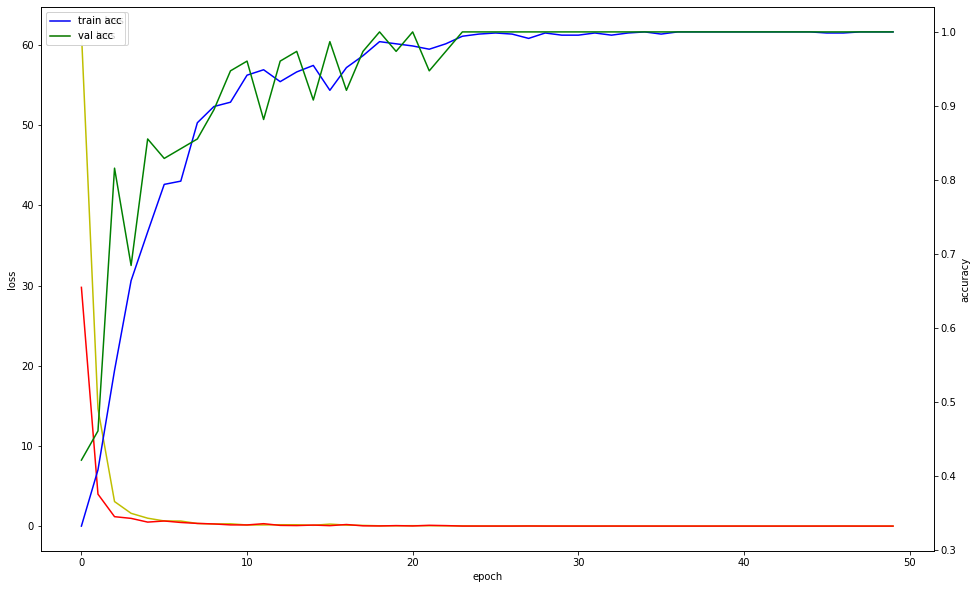

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[56,  0],
        [ 0, 20]],

       [[54,  0],
        [ 0, 22]],

       [[57,  0],
        [ 0, 19]],

       [[61,  0],
        [ 0, 15]]])

In [13]:
from keras.models import load_model

model.save('snowTWO.h5')

from google.colab import files
files.download('snowTWO.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>